In [8]:
using DrWatson
@quickactivate "RL"
# using Conda
# Conda.add("seaborn")
# using PyPlot
# using PyCall
using CSV
using DataFrames
# @pyimport seaborn as sns
# sns.set(font_scale=2)
using Bokeh, BokehBlink

WebIO._IJuliaInit()

In [2]:
n_episodes = 500
title = "4 ports + odor"
csv_name = savename(Dict("title" => title, "n_episodes" => n_episodes), "csv")
csvpath = datadir("sims", csv_name)

"/home/apierre/Dev/RL/data/sims/n_episodes=500_title=4 ports + odor.csv"

In [3]:
function EpisodeBehaviorOdorObsPostProcess(csvpath)
    df = CSV.File(csvpath) |> DataFrame

    # Give a nuber to each port for plotting
    df.S = df.S * 2
    df.E = df.E * 3
    df.W = df.W * 4

    # Get the ports as a chronological sequence
    df.sequence = df.N .| df.S .| df.E .| df.W

    # Get the port of the rewarded/correct episodes
    diffRe = prepend!(diff(circshift(df.Re, -1)), 0)
    df.RePort = circshift(df.stop, -2)
    df.RePort[df.RePort.>0] = df.E[df.RePort.>0] .| df.W[df.RePort.>0]
    df.RePort[diffRe.≠10] .= 0

    # Get the port starting the episode
    df.StartPort = zeros(length(df.start))
    start_idx = findall(df.start .> 0)
    for idx ∈ start_idx
        nextN = findnext(df.N .> 0, idx)
        nextS = findnext(df.S .> 0, idx)

        # Workaround for bug or strange behavior as
        # the environment seems to be restarted a few times at the end
        nextidx = filter!(x ->x != nothing, [nextN, nextS])
        if length(nextidx) == 2
            idx_port = min(nextN, nextS)
        elseif length(nextidx) == 1
            idx_port = nextidx[1]
        end
        if @isdefined idx_port
            df.StartPort[idx_port] = df.sequence[idx_port]
        end
    end
    return df
end

In [3]:
df = EpisodeBehaviorOdorObsPostProcess(csvpath)

51237×11 DataFrame
   Row │ steps  N      S      E      W      Re       start  stop   sequence  R ⋯
       │ Int64  Int64  Int64  Int64  Int64  Float64  Int64  Int64  Int64     I ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │     1      0      0      0      0      0.0      1      0         0    ⋯
     2 │     2      0      0      3      0     -1.0      0      0         3
     3 │     3      0      0      3      0     -2.0      0      0         3
     4 │     4      0      0      0      0     -3.0      0      0         0
     5 │     5      0      0      0      0     -4.0      0      0         0    ⋯
     6 │     6      0      0      0      0     -5.0      0      0         0
     7 │     7      0      0      0      4     -6.0      0      0         4
     8 │     8      0      0      0      4     -7.0      0      0         4
     9 │     9      0      0      0      4     -8.0      0      0         4    ⋯
    10 │    10      0      0      0      4     -9.0      0      0         4
    11 │    11      0      0      0      0    -10.0      0      0         0
   ⋮   │   ⋮      ⋮      ⋮      ⋮      ⋮       ⋮       ⋮      ⋮       ⋮        ⋱
 51228 │ 50730      0      0      0      0   -629.0      0      0         0
 51229 │ 50730      0      0      0      0   -629.0      0      1         0    ⋯
 51230 │ 50731      0      0      0      0      0.0      1      0         0
 51231 │ 50732      0      2      0      0     -1.0      0      0         2
 51232 │ 50733      0      0      0      0      0.0      0      0         0
 51233 │ 50734      0      0      0      0     -1.0      0      0         0    ⋯
 51234 │ 50735      0      0      0      0     -2.0      0      0         0
 51235 │ 50736      0      0      3      0     -3.0      0      0         3
 51236 │ 50737      0      0      0      0      7.0      0      0         0
 51237 │ 50737      0      0      0      0      7.0      0      1         0    ⋯
                                                2 columns and 51216 rows omitted

In [24]:
# function plot_visited_ports(df)
#     PyPlot.figure()
#     fig, ax = plt.subplots(figsize = (25, 10))
#     ax.set_yticks([1, 2, 3, 4])
#     ax.set(xlabel = "Steps", ylabel = "Ports", title = title)
#     ax.set_yticklabels(["North", "South", "East", "West"])
#     cmap = sns.color_palette("tab10")
#     sns.scatterplot(
#         x = df.steps[df.StartPort.>0],
#         y = df.StartPort[df.StartPort.>0],
#         color = "gold",
#         s = 400,
#         marker = "o",
#         legend = "auto",
#         label = "Odor cue",
#     )
#     sns.scatterplot(
#         x = df.steps[df.RePort.>0],
#         y = df.RePort[df.RePort.>0],
#         color = "cyan",
#         s = 400,
#         marker = "o",
#         legend = "auto",
#         label = "Reward"
#     )
#     sns.scatterplot(
#         x = df.steps[df.N.>0],
#         y = df.N[df.N.>0],
#         color = cmap[1],
#         marker = "o",
#         legend = "auto",
#     )
#     sns.scatterplot(
#         x = df.steps[df.S.>0],
#         y = df.S[df.S.>0],
#         color = cmap[2],
#         marker = "o",
#         legend = "auto",
#     )
#     sns.scatterplot(
#         x = df.steps[df.E.>0],
#         y = df.E[df.E.>0],
#         color = cmap[3],
#         marker = "o",
#         legend = "auto",
#     )
#     sns.scatterplot(
#         x = df.steps[df.W.>0],
#         y = df.W[df.W.>0],
#         color = cmap[4],
#         marker = "o",
#         legend = "auto",
#     )
#     sns.lineplot(
#         x = df.steps[df.sequence.>0],
#         y = df.sequence[df.sequence.>0],
#         legend = false,
#         alpha = 0.3,
#     )
#     return fig
# end

plot_visited_ports (generic function with 1 method)

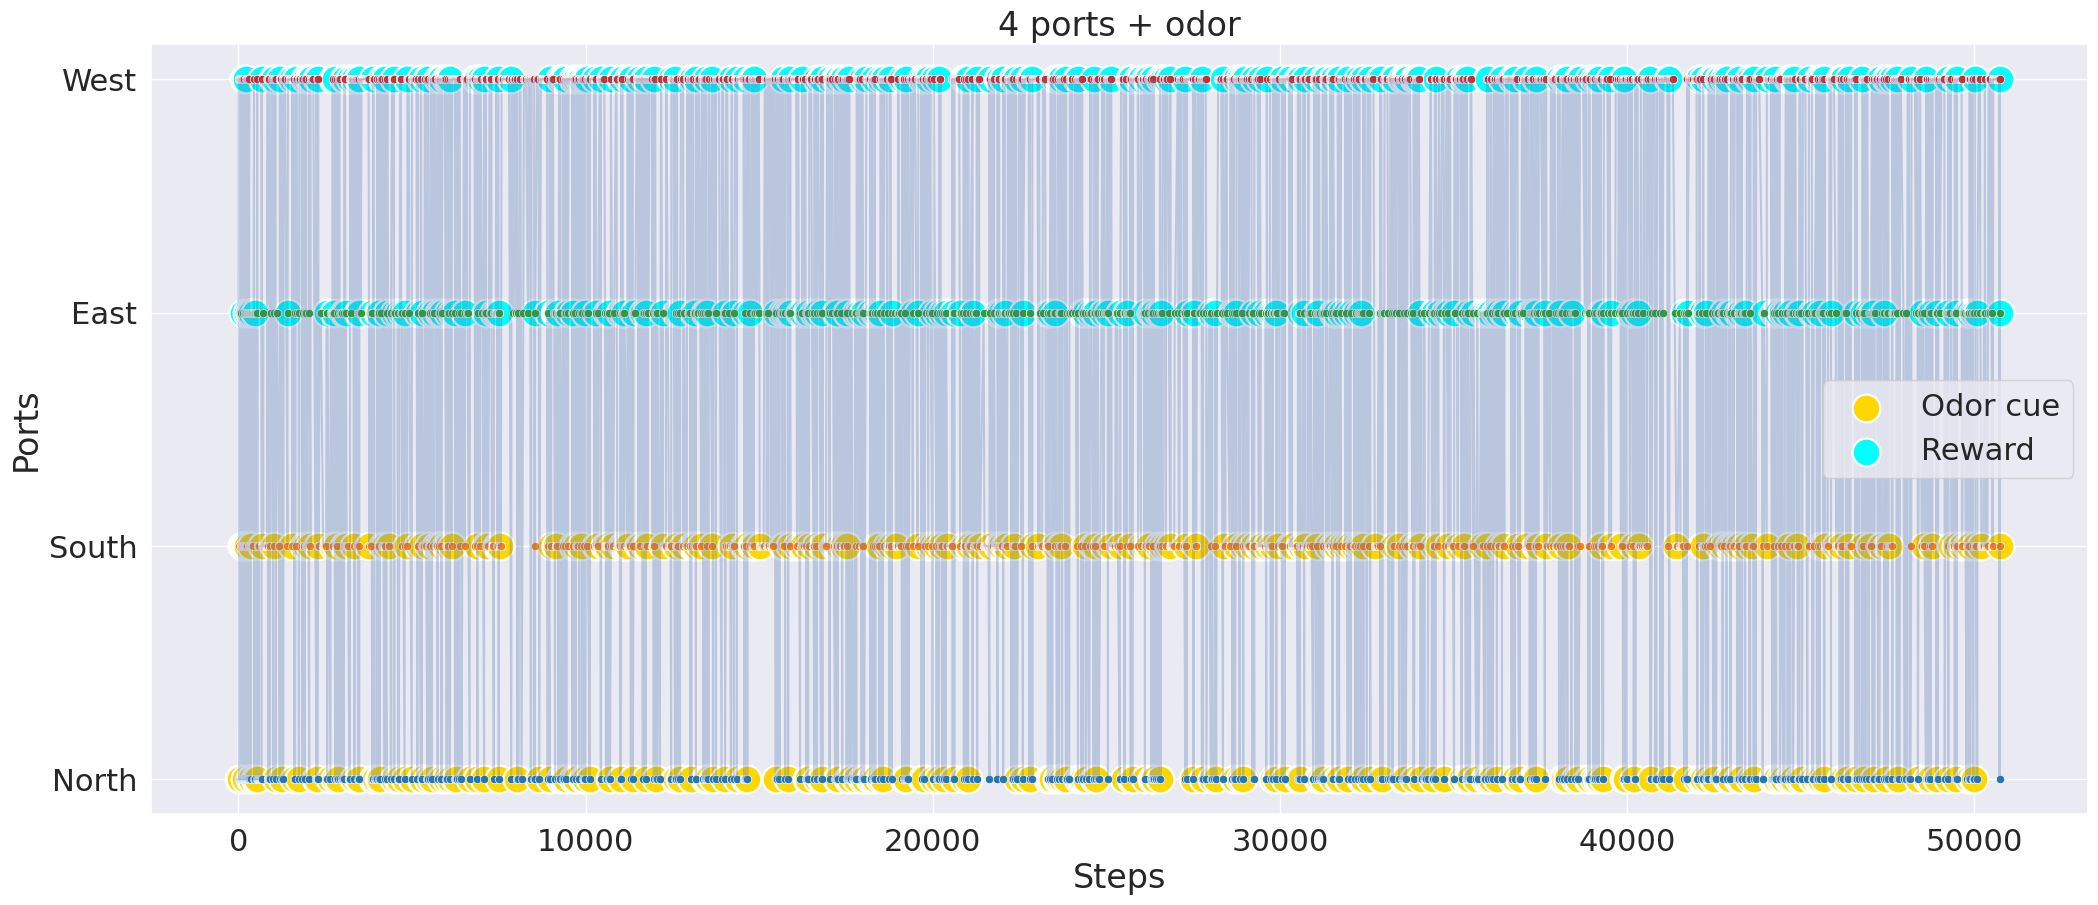

In [25]:
plot_visited_ports(df)
plot_name = savename(Dict("plot" => "visited_ports", "title" => title, "n_episodes" => n_episodes), "png")
plotpath = plotsdir(plot_name)
PyPlot.savefig(plotpath, facecolor = "none", dpi = 300)

In [87]:
# How many rewards did it get ?
df[df.RePort.> 0, :]

489×11 DataFrame
 Row │ steps  N      S      E      W      Re       start  stop   sequence  ReP ⋯
     │ Int64  Int64  Int64  Int64  Int64  Float64  Int64  Int64  Int64     Int ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   136      0      0      3      0    -56.0      0      0         3      ⋯
   2 │   158      0      0      0      4    -18.0      0      0         4
   3 │   213      0      0      0      4    -26.0      0      0         4
   4 │   238      0      0      3      0    -21.0      0      0         3
   5 │   328      0      0      3      0    -86.0      0      0         3      ⋯
   6 │   345      0      0      3      0    -13.0      0      0         3
   7 │   351      0      0      3      0     -2.0      0      0         3
   8 │   464      0      0      3      0   -109.0      0      0         3
   9 │   484      0      0      3      0    -16.0      0      0         3      ⋯
  10 │   667      0      0      0      4   -179.0      0      0         4
  11 │   998      0      0      0      4   -327.0      0      0         4
  ⋮  │   ⋮      ⋮      ⋮      ⋮      ⋮       ⋮       ⋮      ⋮       ⋮        ⋮ ⋱
 480 │ 49778      0      0      3      0   -274.0      0      0         3
 481 │ 49807      0      0      3      0    -25.0      0      0         3      ⋯
 482 │ 49835      0      0      3      0    -24.0      0      0         3
 483 │ 49843      0      0      3      0     -4.0      0      0         3
 484 │ 49969      0      0      3      0   -122.0      0      0         3
 485 │ 49976      0      0      3      0     -3.0      0      0         3      ⋯
 486 │ 50012      0      0      0      4    -32.0      0      0         4
 487 │ 50086      0      0      3      0    -70.0      0      0         3
 488 │ 50729      0      0      0      4   -639.0      0      0         4
 489 │ 50736      0      0      3      0     -3.0      0      0         3      ⋯
                                                  2 columns and 468 rows omitted

In [88]:
df_subset = df[(df.steps.>=0).&(df.steps.<=1500), :]

1517×11 DataFrame
  Row │ steps  N      S      E      W      Re       start  stop   sequence  Re ⋯
      │ Int64  Int64  Int64  Int64  Int64  Float64  Int64  Int64  Int64     In ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │     1      0      0      0      0      0.0      1      0         0     ⋯
    2 │     2      0      0      3      0     -1.0      0      0         3
    3 │     3      0      0      3      0     -2.0      0      0         3
    4 │     4      0      0      0      0     -3.0      0      0         0
    5 │     5      0      0      0      0     -4.0      0      0         0     ⋯
    6 │     6      0      0      0      0     -5.0      0      0         0
    7 │     7      0      0      0      4     -6.0      0      0         4
    8 │     8      0      0      0      4     -7.0      0      0         4
    9 │     9      0      0      0      4     -8.0      0      0         4     ⋯
   10 │    10      0      0      0      4     -9.0      0      0         4
   11 │    11      0      0      0      0    -10.0      0      0         0
  ⋮   │   ⋮      ⋮      ⋮      ⋮      ⋮       ⋮       ⋮      ⋮       ⋮         ⋱
 1508 │  1491      0      0      0      4    -75.0      0      0         4
 1509 │  1492      0      0      0      4    -76.0      0      0         4     ⋯
 1510 │  1493      0      0      0      4    -77.0      0      0         4
 1511 │  1494      0      0      0      4    -78.0      0      0         4
 1512 │  1495      0      0      0      4    -79.0      0      0         4
 1513 │  1496      0      0      0      4    -80.0      0      0         4     ⋯
 1514 │  1497      0      0      0      4    -81.0      0      0         4
 1515 │  1498      0      0      0      4    -82.0      0      0         4
 1516 │  1499      0      0      0      4    -83.0      0      0         4
 1517 │  1500      0      0      0      4    -84.0      0      0         4     ⋯
                                                 2 columns and 1496 rows omitted

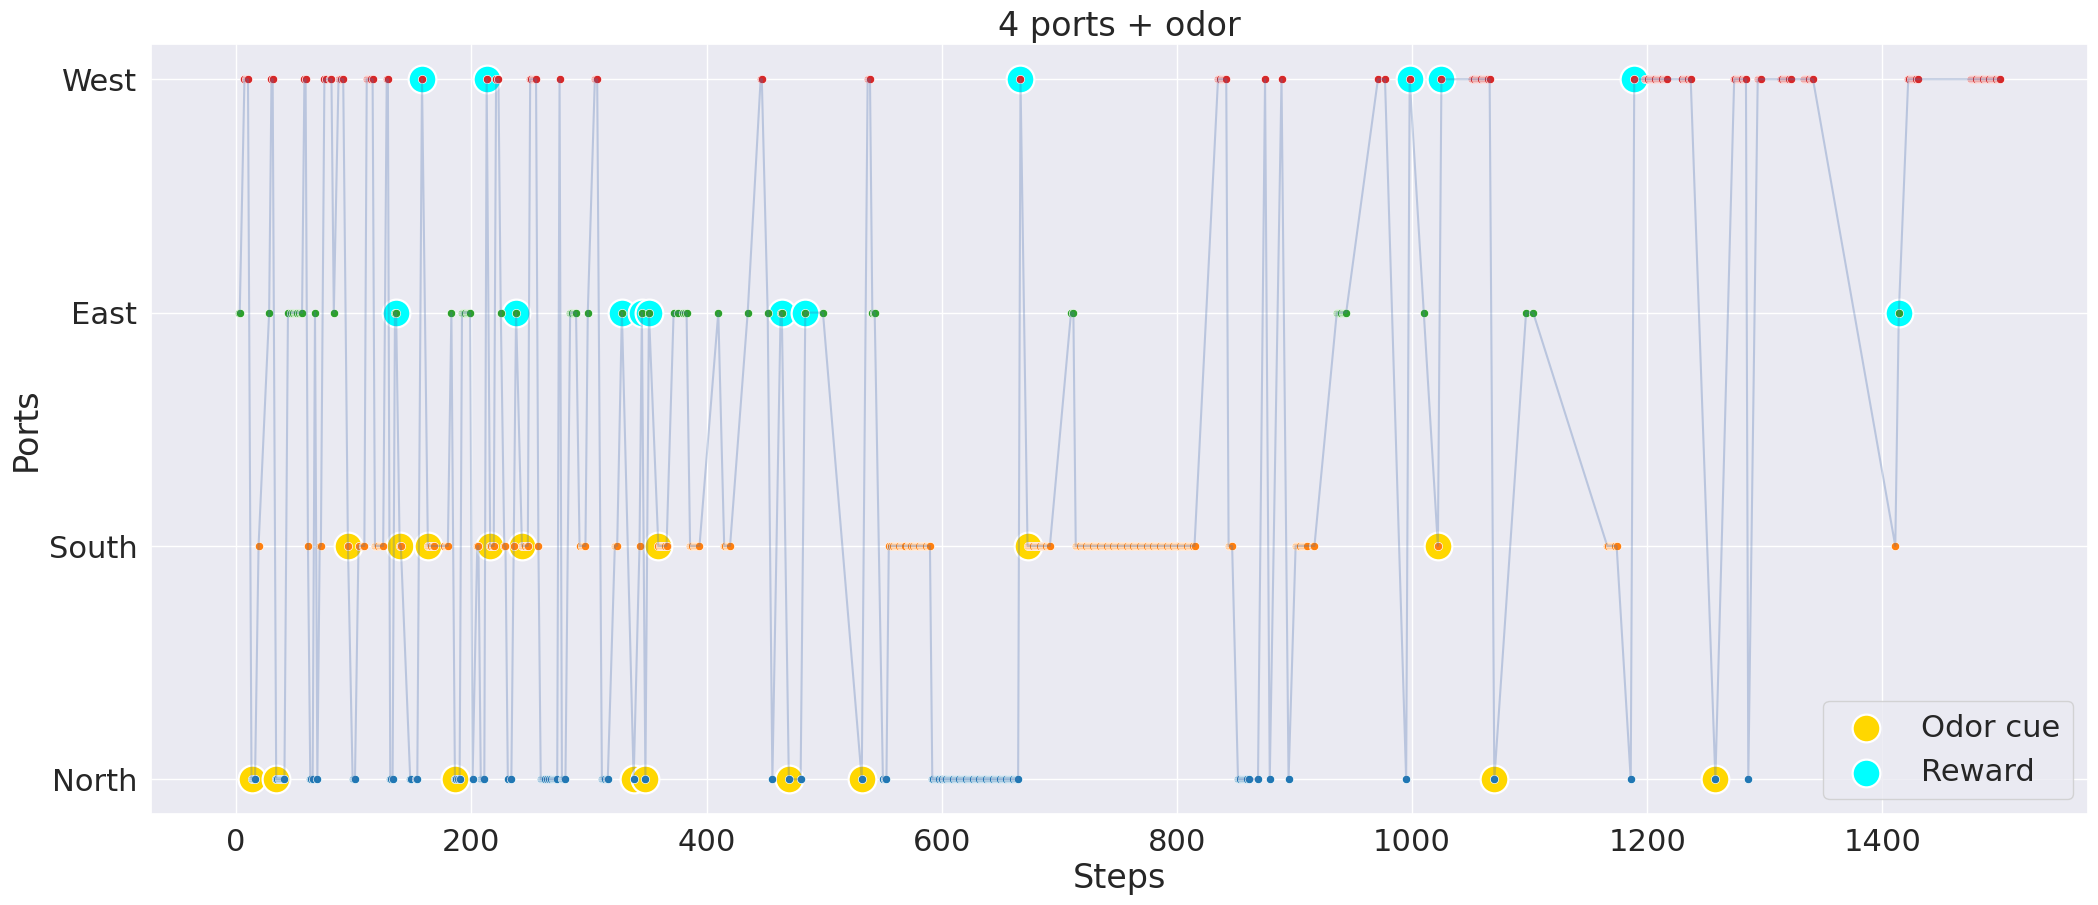

In [34]:
plot_visited_ports(df_subset);

In [85]:
function plot_visited_ports(df)
    p = figure(
        width=1000,
        height=600,
        title="Visited ports",
        x_axis_label="Steps",
        y_axis_label="Ports",
        background_fill_color = "#fafafa",
    )
    p.y_axis.ticker = [1, 2, 3, 4]
    p.y_axis.major_label_overrides = Dict(
        "1" => "North",
        "2" => "South",
        "3" => "East",
        "4" => "West",
    )
    colormap = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

    plot!(p, Line;
        x = df.steps[df.sequence.>0],
        y = df.sequence[df.sequence.>0],
        line_alpha=0.3,
    )
    plot!(p, Scatter,
        x = x = df.steps[df.StartPort.>0],
        y = df.StartPort[df.StartPort.>0],
        legend_label="Odor cue",
        fill_alpha=0.4,
        size=12,
        color="gold",
    )
    plot!(p, Scatter,
        x = df.steps[df.RePort.>0],
        y = df.RePort[df.RePort.>0],
        legend_label="Reward",
        fill_alpha=0.4,
        size=12,
        color="cyan",
    )
    plot!(p, Scatter,
        x = df.steps[df.N.>0],
        y = df.N[df.N.>0],
#         fill_alpha=0.4,
#         size=12,
        color = colormap[1],
    )
    plot!(p, Scatter,
        x = df.steps[df.S.>0],
        y = df.S[df.S.>0],
#         fill_alpha=0.4,
#         size=12,
        color = colormap[2],
    )
    plot!(p, Scatter,
        x = df.steps[df.E.>0],
        y = df.E[df.E.>0],
#         fill_alpha=0.4,
#         size=12,
        color = colormap[3],
    )
    plot!(p, Scatter,
        x = df.steps[df.W.>0],
        y = df.W[df.W.>0],
#         fill_alpha=0.4,
#         size=12,
        color = colormap[4],
    )
    return p
end

plot_visited_ports (generic function with 1 method)

In [86]:
p = plot_visited_ports(df)
plot_name = savename(Dict("plot" => "visited_ports", "title" => title, "n_episodes" => n_episodes), "png")
plotpath = plotsdir(plot_name)
BokehBlink.save(plotpath, p)
print(plotpath)
p

/home/apierre/Dev/RL/plots/n_episodes=500_plot=visited_ports_title=4 ports + odor.png

Figure:
  above = []
  background_fill_color = "#fafafa"
  below = [
    LinearAxis:
      axis_label = "Steps"
  ]
  center = [
    Grid:
      axis = ...
      dimension = 0
    Grid:
      axis = LinearAxis:
        axis_label = "Ports"
        major_label_overrides = Dict(
          "4" => "West"
          "1" => "North"
          "2" => "South"
          "3" => "East"
        )
        ticker = FixedTicker:
          ticks = [
            1.0
            2.0
            3.0
            4.0
          ]
      dimension = 1
    Legend:
      items = [
        LegendItem:
          label = Value("Odor cue")
          renderers = [
            GlyphRenderer:
              data_source = ColumnDataSource:
                data = Dict(
                  "x" => [
                    13
                    34
                    95
                    139
                    163
                    ...
                  ]
                  "y" => [
                    1.0
                    1.0
                    2.0
                    2.0
                    2.0
                    ...
                  ]
                )
              glyph = Scatter:
                fill_alpha = Value(0.4)
                fill_color = Value("#ffd700")
                hatch_color = Value("#ffd700")
                line_color = Value("#ffd700")
                size = Value(12.0)
                x = Field("x")
                y = Field("y")
              view = CDSView:
                source = ...
          ]
        LegendItem:
          label = Value("Reward")
          renderers = [
            GlyphRenderer:
              data_source = ColumnDataSource:
                data = Dict(
                  "x" => [
                    136
                    158
                    213
                    238
                    328
                    ...
                  ]
                  "y" => [
                    3
                    4
                    4
                    3
                    3
                    ...
                  ]
                )
              glyph = Scatter:
                fill_alpha = Value(0.4)
                fill_color = Value("#00ffff")
                hatch_color = Value("#00ffff")
                line_color = Value("#00ffff")
                size = Value(12.0)
                x = Field("x")
                y = Field("y")
              view = CDSView:
                source = ...
          ]
      ]
  ]
  height = 600
  left = [
    ...
  ]
  renderers = [
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            2
            3
            7
            8
            9
            ...
          ]
          "y" => [
            3
            3
            4
            4
            4
            ...
          ]
        )
      glyph = Line:
        line_alpha = 0.3
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    ...
    ...
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            13
            14
            15
            16
            34
            ...
          ]
          "y" => [
            1
            1
            1
            1
            1
            ...
          ]
        )
      glyph = Scatter:
        fill_color = Value("#1f77b4")
        hatch_color = Value("#1f77b4")
        line_color = Value("#1f77b4")
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            19
            61
            71
            72
            95
            ...
          ]
          "y" => [
            2
            2
            2
            2
            2
            ...
          ]
        )
      glyph = Scatter:
        fill_color = Value("#ff7f0e")
        hatch_color = Value("#ff7f0e")
        line_col

In [89]:
plot_visited_ports(df_subset)

Figure:
  above = []
  background_fill_color = "#fafafa"
  below = [
    LinearAxis:
      axis_label = "Steps"
  ]
  center = [
    Grid:
      axis = ...
      dimension = 0
    Grid:
      axis = LinearAxis:
        axis_label = "Ports"
        major_label_overrides = Dict(
          "4" => "West"
          "1" => "North"
          "2" => "South"
          "3" => "East"
        )
        ticker = FixedTicker:
          ticks = [
            1.0
            2.0
            3.0
            4.0
          ]
      dimension = 1
    Legend:
      items = [
        LegendItem:
          label = Value("Odor cue")
          renderers = [
            GlyphRenderer:
              data_source = ColumnDataSource:
                data = Dict(
                  "x" => [
                    13
                    34
                    95
                    139
                    163
                    ...
                  ]
                  "y" => [
                    1.0
                    1.0
                    2.0
                    2.0
                    2.0
                    ...
                  ]
                )
              glyph = Scatter:
                fill_alpha = Value(0.4)
                fill_color = Value("#ffd700")
                hatch_color = Value("#ffd700")
                line_color = Value("#ffd700")
                size = Value(12.0)
                x = Field("x")
                y = Field("y")
              view = CDSView:
                source = ...
          ]
        LegendItem:
          label = Value("Reward")
          renderers = [
            GlyphRenderer:
              data_source = ColumnDataSource:
                data = Dict(
                  "x" => [
                    136
                    158
                    213
                    238
                    328
                    ...
                  ]
                  "y" => [
                    3
                    4
                    4
                    3
                    3
                    ...
                  ]
                )
              glyph = Scatter:
                fill_alpha = Value(0.4)
                fill_color = Value("#00ffff")
                hatch_color = Value("#00ffff")
                line_color = Value("#00ffff")
                size = Value(12.0)
                x = Field("x")
                y = Field("y")
              view = CDSView:
                source = ...
          ]
      ]
  ]
  height = 600
  left = [
    ...
  ]
  renderers = [
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            2
            3
            7
            8
            9
            ...
          ]
          "y" => [
            3
            3
            4
            4
            4
            ...
          ]
        )
      glyph = Line:
        line_alpha = 0.3
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    ...
    ...
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            13
            14
            15
            16
            34
            ...
          ]
          "y" => [
            1
            1
            1
            1
            1
            ...
          ]
        )
      glyph = Scatter:
        fill_color = Value("#1f77b4")
        hatch_color = Value("#1f77b4")
        line_color = Value("#1f77b4")
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            19
            61
            71
            72
            95
            ...
          ]
          "y" => [
            2
            2
            2
            2
            2
            ...
          ]
        )
      glyph = Scatter:
        fill_color = Value("#ff7f0e")
        hatch_color = Value("#ff7f0e")
        line_col